In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../data/clean_spring.csv", sep=';')

In [3]:
Xdata = data.drop('winA', axis=1)
ydata = data.winA

In [4]:
rd_seed = 333
from sklearn.model_selection import train_test_split

In [5]:
Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size=0.4, random_state=rd_seed)
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(393, 62)
(393,)
(263, 62)
(263,)


In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
clf = DecisionTreeClassifier(max_depth=50, random_state=42)
clf.fit(Xtrain, ytrain)

,criterion,'gini'
,splitter,'best'
,max_depth,50
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [8]:
import sklearn.metrics as metrics

In [9]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clf.predict(Xtrain))))

accuracy score (train): 0.959288


In [10]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(yval, clf.predict(Xval))))

accuracy score (test): 0.623574


In [11]:
val_acc = []
train_acc = []
depths = range(1,101)
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state = 42)
    clf.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

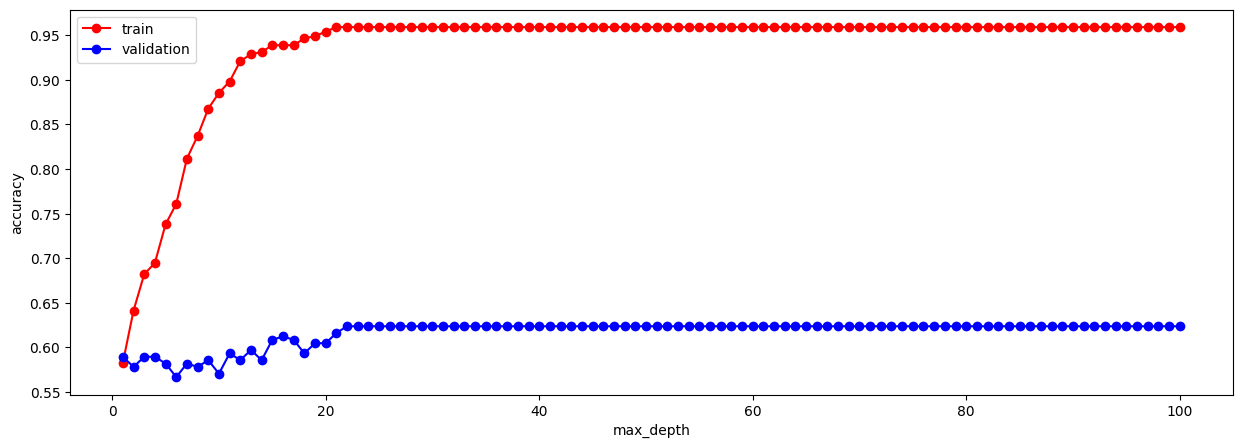

In [13]:
plt.figure(figsize=(15,5))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [14]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

np.int64(22)

In [15]:
tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state = 42)
tree.fit(Xtrain, ytrain)
print('TREE accuracy score (val): {0:.6f}'.format(metrics.accuracy_score(yval, clf.predict(Xval)) * 100))

TREE accuracy score (val): 62.357414


In [16]:
from sklearn.ensemble import RandomForestClassifier
clfRF = RandomForestClassifier(n_estimators = 30, max_depth = 8, random_state = 42)
clfRF.fit(Xtrain, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, clfRF.predict(Xval))))

Accuracy score (validation): 0.638783


In [17]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_estimators': range(15,25),
    'max_depth': range(10,30)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clf = RandomForestClassifier(**params, random_state = 42).fit(Xtrain, ytrain)
    val_metric.append(metrics.accuracy_score(yval, clf.predict(Xval)))
    
best_params = param_comb[np.argmax(val_metric)]
print(f"We found the best params {best_params} with validation acuraccy {100*max(val_metric):.4f}.")
forest = RandomForestClassifier(**best_params, random_state = 42).fit(Xtrain, ytrain)

We found the best params {'n_estimators': 21, 'max_depth': 21} with validation acuraccy 68.4411.


In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtrain, ytrain)
print(f"Validation accuracy: {metrics.accuracy_score(yval, clf.predict(Xval)):0.4f}")

Validation accuracy: 0.6274


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

Xval_scaled = scaler.transform(Xval)

clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled, ytrain)

print(f"Validation accuracy of normalized model: {clf.score(Xval_scaled, yval):0.4f}")

Validation accuracy of normalized model: 0.6426


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

Xval_scaled = scaler.transform(Xval)

clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled, ytrain)

print(f"Validation accuracy of normalized model: {clf.score(Xval_scaled, yval):0.4f}")

Validation accuracy of normalized model: 0.6540


In [22]:
val_acc = []
train_acc = []

kneighbors = range(3,40)
for k in kneighbors:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(Xtrain_scaled, ytrain)
    val_acc.append(clf.score(Xval_scaled, yval))
    train_acc.append(clf.score(Xtrain_scaled, ytrain))

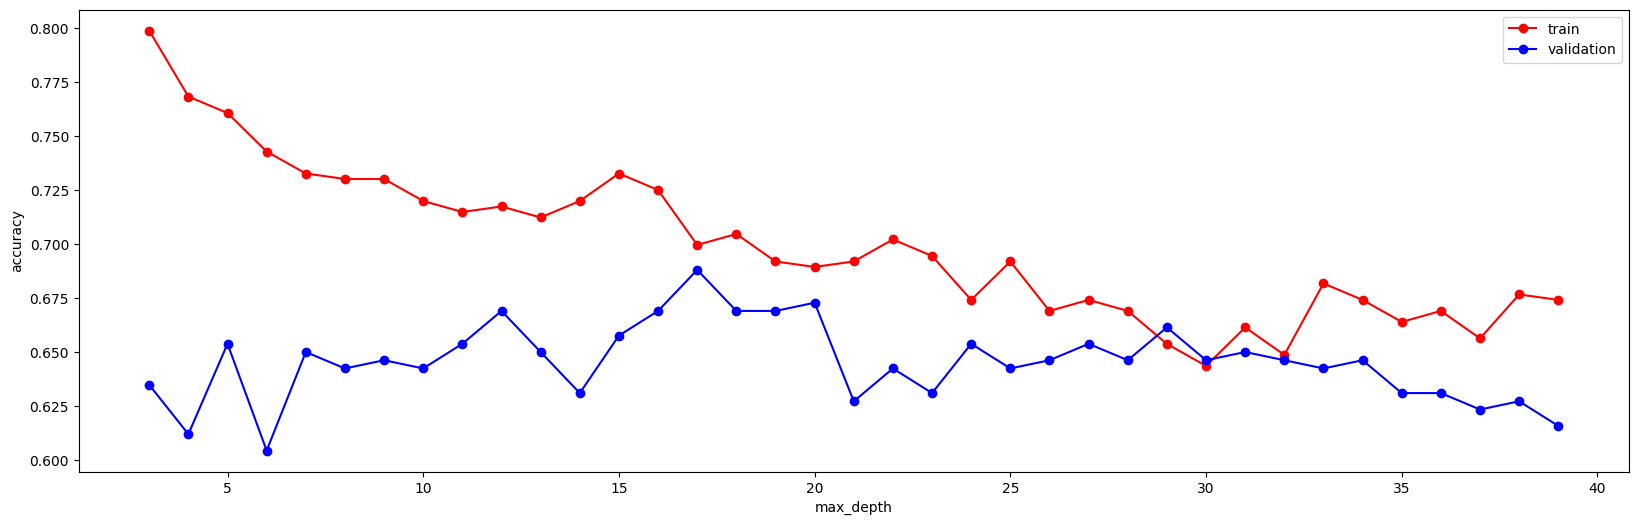

In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(kneighbors, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(kneighbors, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [24]:
import numpy as np

best_val_acc = max(val_acc)
best_k_index = np.argmax(val_acc)  # nebo val_acc.index(best_val_acc)
best_k = kneighbors[best_k_index]

from sklearn.model_selection import cross_val_score

clf = KNeighborsClassifier(n_neighbors = 17)
clf.fit(Xtrain_scaled, ytrain)

fold_acc = cross_val_score(clf, Xtrain_scaled, ytrain, cv=5)
print(np.mean(fold_acc))


print(f"Nejlepší val acc: {best_val_acc:.4f} při k = {best_k}")

0.63862382343395
Nejlepší val acc: 0.6882 při k = 17


In [25]:
from sklearn.model_selection import KFold
# ohodnocení pro jednu sadu hyperparametrů už natrénovaného modelu

num_folds = 5
kf = KFold(n_splits = num_folds)
fold_acc = []
for i, (train_index, val_index) in enumerate(kf.split(Xtrain)):
    tX_train, tX_val = Xtrain.iloc[train_index,:], Xtrain.iloc[val_index,:]
    ty_train, ty_val = ytrain.iloc[train_index], ytrain.iloc[val_index]
    print(f"Trénovací množina: {tX_train.shape}, validační množina: {tX_val.shape}")

    clf = DecisionTreeClassifier(max_depth = 22, random_state = 42)
    clf.fit(tX_train, ty_train)
    one_fold_acc = metrics.accuracy_score(ty_val, clf.predict(tX_val))
    print(f"Přesnost na foldu {i + 1} z {num_folds}: {one_fold_acc:.4f}\n")
    fold_acc.append(one_fold_acc)

mean_cv_acc = np.mean(fold_acc)
print(f"Průměrná přesnost: {mean_cv_acc:.6f}")

Trénovací množina: (314, 62), validační množina: (79, 62)
Přesnost na foldu 1 z 5: 0.6076

Trénovací množina: (314, 62), validační množina: (79, 62)
Přesnost na foldu 2 z 5: 0.6709

Trénovací množina: (314, 62), validační množina: (79, 62)
Přesnost na foldu 3 z 5: 0.5190

Trénovací množina: (315, 62), validační množina: (78, 62)
Přesnost na foldu 4 z 5: 0.6923

Trénovací množina: (315, 62), validační množina: (78, 62)
Přesnost na foldu 5 z 5: 0.6282

Průměrná přesnost: 0.623596


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 30)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clf = KNeighborsClassifier(**params)
    # cross validation
    fold_acc = cross_val_score(clf, Xtrain_scaled, ytrain, cv=5)
    val_metric.append(np.mean(fold_acc))
    
best_knn_params = param_comb[np.argmax(val_metric)]
best_knn_metric = max(val_metric)
print(f"Našli jsme nejlepší hyperparametry {best_knn_params} s kross validační přesností {best_knn_metric:.4f}.")

Našli jsme nejlepší hyperparametry {'n_neighbors': 14} s kross validační přesností 0.6462.


In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [29]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

model.fit(Xtrain, ytrain)
print("Acc: ", accuracy_score(yval, model.predict(Xval)))

Acc:  0.6463878326996197


In [55]:
param_grid = {
    'n_estimators': range(40,60),
    'max_depth': range(3,9),
    'learning_rate': [0.05, 0.1],
    'subsample': [0.4,0.45,0.5,0.55,0.6,0.65,0.7],
    'colsample_bytree': [0.8],
}

# Vygeneruj všechny kombinace
grid = ParameterGrid(param_grid)

best_score = 0
best_params = None

for params in grid:
    
    # Vytvoř model s danými parametry
    model = XGBClassifier(
        **params,
        eval_metric='logloss',
    )
    
    # Trénink
    model.fit(Xtrain, ytrain)
    
    # Predikce a hodnocení
    y_pred = model.predict(Xval)
    acc = accuracy_score(yval, y_pred)
    
    if acc > best_score:
        best_score = acc
        best_params = params

print("🔍 Nejlepší kombinace parametrů:", best_params)
print(f"✅ Nejlepší přesnost: {best_score:.4f}")

🔍 Nejlepší kombinace parametrů: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 46, 'subsample': 0.45}
✅ Nejlepší přesnost: 0.7034


In [62]:
from sklearn.linear_model import LogisticRegression

clfLOG = LogisticRegression(solver='newton-cg')
clfLOG.fit(Xtrain,ytrain)

print('Trénovací přesnost:', clfLOG.score(Xtrain,ytrain))
print('\nValidační přesnost:', clfLOG.score(Xval,yval))


Trénovací přesnost: 0.7150127226463104

Validační přesnost: 0.6273764258555133


In [58]:
from scipy.special import expit

In [63]:
# Matice X
XX = np.matrix(np.concatenate([np.ones((Xtrain.shape[0],1)),np.array(Xtrain)], axis = 1))
XX

# Vektor Y
YY = np.matrix(ytrain).T

# gradient
def get_grad(w, XX, YY):
    PP = expit(XX*w)
    return XX.T*(YY - PP)

w_hat = np.matrix(np.ones((XX.shape[1],1)))

alpha = 0.3
for i in range(30000):
    # get gradient
    grad = get_grad(w_hat, XX, YY)
    w_hat = w_hat + alpha/(1+i)*grad


Ptrain = np.array(expit(XX*w_hat)).flatten()
Yhattrain = np.array(Ptrain > 0.5, dtype = int)

XXval = np.matrix(np.concatenate([np.ones((Xval.shape[0],1)),np.array(Xval)], axis = 1))
Pval = np.array(expit(XXval*w_hat)).flatten()
Yhatval = np.array(Pval > 0.5, dtype = int)


from sklearn.metrics import accuracy_score
print('\nTrénovací přesnost:', accuracy_score(ytrain, Yhattrain))
print('Validační přesnost:', accuracy_score(yval, Yhatval))


Trénovací přesnost: 0.6030534351145038
Validační přesnost: 0.6425855513307985
